In [23]:
%run setup.ipynb
%matplotlib inline
import hapclust
# %reload_ext autoreload
# %autoreload 1
# %aimport hapclust

In [2]:
# obtain data from unphased callset - only needed for variant annotations
callset_pass = phase1_ar31.callset_pass
pos_pass = allel.SortedIndex(callset_pass['2L/variants/POS'])
ann_pass = callset_pass['2L/variants/ANN'][:][['Annotation', 'HGVS_p']]

In [3]:
# setup haplotype data
callset_phased = phase1_ar31.callset_phased
genotypes_phased = allel.GenotypeDaskArray(callset_phased['2L/calldata/genotype'])
pos_phased = allel.SortedIndex(callset_phased['2L/variants/POS'])

In [4]:
pos_kdr_s = 2422651
pos_kdr_f = 2422652

In [141]:
region_vgsc = SeqFeature('2L', 2358158, 2431617)
region_vgsc

<SeqFeature 2L:2358158-2431617>

In [5]:
# define region we're going to analyse
loc_region = pos_phased.locate_range(0, 4000000)
pos_phased_region = pos_phased[loc_region]
pos_phased_region

0,1,2,3,4,...,163958,163959,163960,163961,163962
44688,44691,44732,44736,44756,...,3997372,3997373,3997378,3997381,3997386


In [6]:
# locate the intersection with unphased callset - needed to tie in annotations
loc1, _ = pos_pass.locate_intersection(pos_phased_region)
np.count_nonzero(loc1)

163963

In [7]:
ann_phased_region = ann_pass[loc1]
ann_phased_region

array([(b'intergenic_region', b'.'), (b'intergenic_region', b'.'),
       (b'intergenic_region', b'.'), ...,
       (b'downstream_gene_variant', b'.'),
       (b'downstream_gene_variant', b'.'),
       (b'downstream_gene_variant', b'.')], 
      dtype=[('Annotation', 'S34'), ('HGVS_p', 'S14')])

In [8]:
# exclude cross parents
haps_phased_region = genotypes_phased[loc_region].to_haplotypes()[:, :-16].compute()
haps_phased_region

<HaplotypeArray shape=(163963, 1530) dtype=int8>
0 0 0 0 0 ... 0 0 0 0 0
0 0 0 0 0 ... 0 0 0 0 0
0 0 0 0 0 ... 0 0 0 0 0
...
0 0 0 0 0 ... 0 0 0 0 0
0 0 0 0 0 ... 0 0 0 0 0
0 0 0 0 0 ... 0 0 0 0 0

In [9]:
# perform allele count - needed to locate singletons
ac_phased_region = haps_phased_region.count_alleles(max_allele=1)

In [10]:
# define types of variants to include in EHH analysis - should be mostly neutral
loc_type_neutral = ((ann_phased_region['Annotation'] == b'intergenic_region') | 
                    (ann_phased_region['Annotation'] == b'intron_variant') |
                    (ann_phased_region['Annotation'] == b'downstream_gene_variant') |
                    (ann_phased_region['Annotation'] == b'upstream_gene_variant') |
                    (ann_phased_region['Annotation'] == b'synonymous_variant') |
                    (ann_phased_region['Annotation'] == b'3_prime_UTR_variant') |
                    (ann_phased_region['Annotation'] == b'5_prime_UTR_variant') 
                    )
np.count_nonzero(loc_type_neutral), loc_type_neutral.shape

(156848, (163963,))

In [11]:
# locate singletons - will exclude from EHH analysis
loc_sgl = ac_phased_region.min(axis=1) == 1
loc_nosgl = ac_phased_region.min(axis=1) > 1
np.count_nonzero(loc_sgl), np.count_nonzero(loc_nosgl), loc_nosgl.shape

(52218, 111614, (163963,))

In [12]:
# these are the variants to use for EHH
loc_ehh = loc_type_neutral & loc_nosgl
np.count_nonzero(loc_ehh), loc_ehh.shape

(107533, (163963,))

In [13]:
haps_ehh = haps_phased_region[loc_ehh]
pos_ehh = pos_phased_region[loc_ehh]

In [14]:
core_pos = pos_kdr_f

In [15]:
is_accessible = phase1_ar3.accessibility['2L/is_accessible'][:]

In [56]:
%%cython


# cython: boundscheck=False
# cython: wraparound=False


cimport numpy as np
import numpy as np


def reconstruct_ancestral_haplotype_flank(np.int8_t[:, :] haps_flank):
   
    cdef:
        Py_ssize_t n_variants, n_haplotypes, i, j
        np.uint8_t[:] clust_anc
        np.int32_t[:] ac
        np.int8_t[:] hap_anc
        np.int8_t allele
    
    # setup intermediates and outputs
    n_variants, n_haplotypes = haps_flank.shape[:2]
    clust_anc = np.ones(n_haplotypes, dtype='u1')
    ac = np.zeros(2, dtype='i4')
    hap_anc = np.full(n_variants, dtype='i1', fill_value=-1)
    
    # iterate over variants
    for i in range(n_variants):
                
        # count alleles within the ancestral cluster
        ac[:] = 0  # reset
        for j in range(n_haplotypes):
            if clust_anc[j]:
                allele = haps_flank[i, j]
                if allele >= 0:
                    ac[allele] += 1
                    
        # find ancestral allele
        if ac[0] >= ac[1]:
            # if tie, assume reference
            anc_allele = 0
            der_allele = 1
        else:
            anc_allele = 1
            der_allele = 0
        # patch into ancestral haplotype
        hap_anc[i] = anc_allele

        # detect bifurcation
        if ac[0] > 0 and ac[1] > 0:
            # split cluster
            for j in range(n_haplotypes):
                if clust_anc[j]:
                    if haps_flank[i, j] == der_allele:
                        clust_anc[j] = 0

        # bail out if only one haplotype left
        if ac[anc_allele] < 2:
            break
            
    return hap_anc


In [57]:
def reconstruct_ancestral_haplotype(haps, pos, core_pos):
    """Reconstruct the putative ancestral haplotype from the flank of a selective sweep, 
    using the majority rule."""

    # split flanks
    _, _, haps_right, haps_left = hapclust.split_flanks(
        haps, pos, core_pos
    )    
    
    # reconstruct ancestral haplotype for each flank
    hap_right_anc = reconstruct_ancestral_haplotype_flank(np.asarray(haps_right, dtype='i1'))
    hap_left_anc = reconstruct_ancestral_haplotype_flank(np.asarray(haps_left, dtype='i1'))
    
    # join back together
    hap_anc = np.concatenate([hap_left_anc[::-1], hap_right_anc])
    
    return hap_anc


In [58]:
# TODO rerun after clustering has been fixed

In [59]:
import pickle
with open('../data/clust_dict.pickle', 'rb') as handle:
    vgsc_haplogroups = pickle.load(handle) 
sorted(vgsc_haplogroups.keys())

['F1', 'F2', 'F3', 'F4', 'F5', 'L1', 'L2', 'S1', 'S2', 'S3', 'S4/5']

In [60]:
def get_haps(hg):
    return haps_ehh.take(sorted(vgsc_haplogroups[hg]), axis=1)

In [62]:
hap_f1_anc = reconstruct_ancestral_haplotype(get_haps('F1'), pos_ehh, pos_kdr_f)
hap_f1_anc

array([ 0,  0,  1, ..., -1, -1, -1], dtype=int8)

In [102]:
sns.set_style('darkgrid')

In [174]:
def plot_divergence(haps, hap_anc, xlim=(0, 3500000), ylim=(-0.0005, 0.013), window_size=10000, ax=None, color='k', lw=1, alpha=.2):
    
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 2), dpi=120)
#         sns.despine(ax=ax, offset=3)
    
    windows = allel.equally_accessible_windows(is_accessible, size=window_size)
    x = np.mean(windows, axis=1)
    
    for j in range(haps.shape[1]):
        h = haps[:, j]
        values = h != hap_anc
        d, _, _ = allel.windowed_statistic(pos=pos_ehh, values=values, statistic=np.sum, windows=windows)
        ax.plot(x, d/window_size, color=color, lw=lw, alpha=alpha)
        
    ax.axvspan(region_vgsc.start, region_vgsc.end, color='k', alpha=.3)
    ax.annotate('$Vgsc$', xy=(region_vgsc.start/(xlim[1]-xlim[0]), 1), xycoords='axes fraction',
                xytext=(0, 5), textcoords='offset points', fontsize=8)

    xticks = np.arange(0, xlim[1], 500000)
    xticklabels = xticks/1e6
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticklabels)
    ax.set_xlim(*xlim)
    ax.set_ylim(*ylim)
    ax.set_ylabel('$D_{xy}$')
    ax.set_xlabel('Position (Mbp)')
    return ax
    

In [175]:
hap_s1_anc = reconstruct_ancestral_haplotype(get_haps('S1'), pos_ehh, pos_kdr_f)

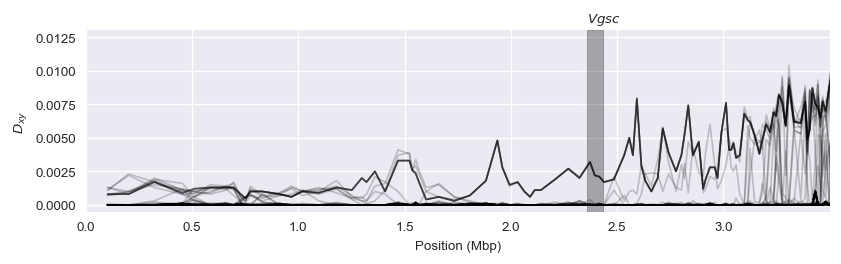

In [176]:
plot_divergence(get_haps('S1'), hap_s1_anc);

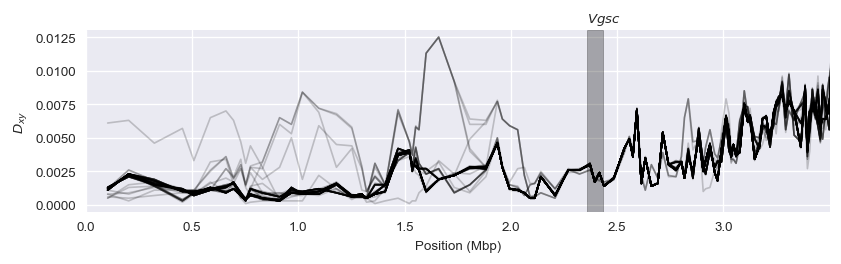

In [177]:
plot_divergence(get_haps('S2'), hap_s1_anc);

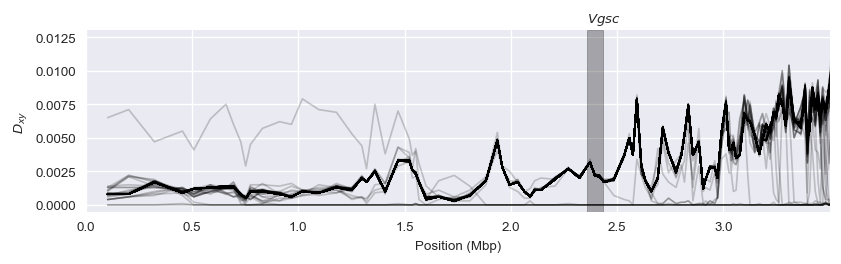

In [178]:
plot_divergence(get_haps('S3'), hap_s1_anc);

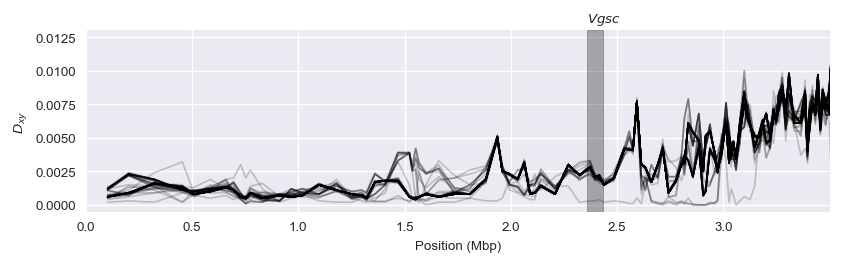

In [179]:
plot_divergence(get_haps('S4/5'), hap_s1_anc);

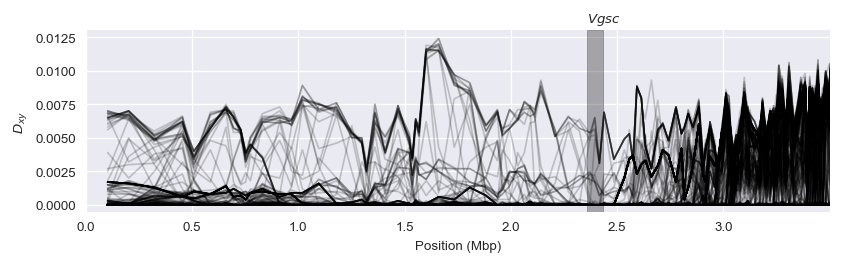

In [180]:
plot_divergence(get_haps('F1'), hap_f1_anc);

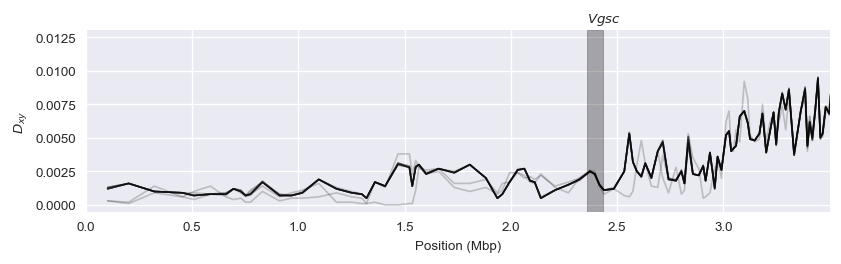

In [181]:
plot_divergence(get_haps('F2'), hap_f1_anc);

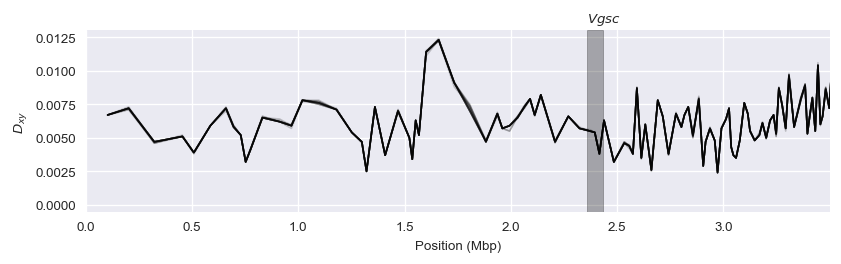

In [182]:
plot_divergence(get_haps('L1'), hap_f1_anc);

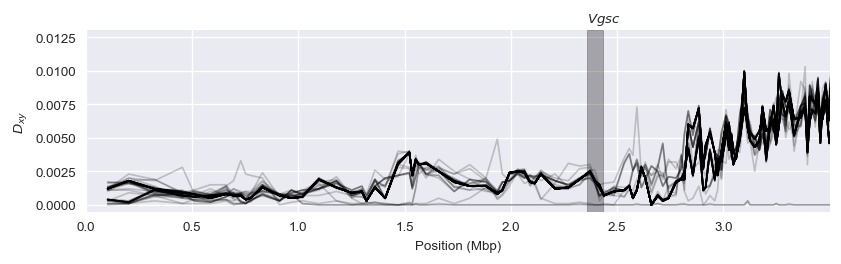

In [183]:
plot_divergence(get_haps('S4/5'), hap_f1_anc);

## Sandbox

In [63]:
haps_f1_left = haps_ehh_left.take(list(vgsc_haplogroups['F1']), axis=1)
haps_f1_left

<HaplotypeArray shape=(15754, 456) dtype=int8>
0 0 0 0 0 ... 0 0 0 0 0
0 0 0 0 0 ... 0 0 0 0 0
0 0 0 0 0 ... 0 0 0 0 0
...
1 1 1 1 1 ... 1 1 1 1 1
0 0 0 0 0 ... 0 0 0 0 0
0 0 0 0 0 ... 0 0 0 0 0

In [64]:
hap_f1_right_anc = reconstruct_ancestral_haplotype(haps_f1_right)

In [65]:
hap_f1_right_anc[:10]

array([0, 0, 1, 1, 0, 0, 0, 0, 0, 0], dtype=int8)

In [68]:
np.nonzero(hap_f1_right_anc == -1)[0].min()

48469

In [69]:
hap_f1_right_anc.shape

(91779,)

In [70]:
hap_f1_left_anc = reconstruct_ancestral_haplotype(haps_f1_left)

In [72]:
hap_f1_left_anc

array([0, 0, 0, ..., 1, 0, 0], dtype=int8)

In [73]:
hap_f1_anc = np.concatenate([hap_f1_left_anc[::-1], hap_f1_right_anc])

In [75]:
np.count_nonzero(hap_f1_anc >= 0)

64223

In [76]:
haps_f1 = haps_ehh.take(list(vgsc_haplogroups['F1']), axis=1)

In [86]:
haps_f1

<HaplotypeArray shape=(107533, 456) dtype=int8>
0 0 0 0 0 ... 0 0 0 0 0
0 0 0 0 0 ... 0 0 0 0 0
1 1 1 1 1 ... 1 1 1 1 1
...
0 0 0 0 0 ... 0 0 0 0 0
0 0 0 0 0 ... 0 0 0 0 0
0 0 0 0 0 ... 0 0 0 0 0

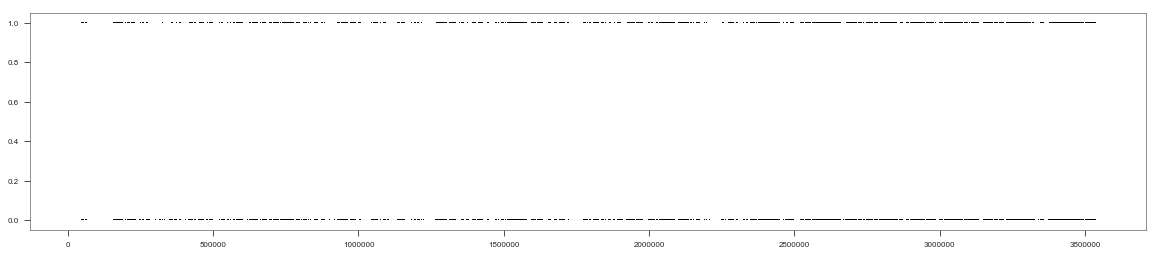

In [92]:
fig, ax = plt.subplots(figsize=(20, 4))

mask = hap_f1_anc == -1
x = np.ma.array(pos_ehh, mask=mask)
y = np.ma.array(hap_f1_anc, mask=mask)
ax.plot(x, y, 'k,');

In [119]:
def plot_divergence(haps, hap_anc, xlim=(0, 4000000), ylim=(-0.001, 0.015), window_size=20000):
    
    fig, ax = plt.subplots(figsize=(20, 4))
    sns.despine(ax=ax, offset=3)
    windows = allel.equally_accessible_windows(is_accessible, size=window_size)
    x = np.mean(windows, axis=1)
    
    for j in range(haps.shape[1]):
        h = haps[:, j]
        values = h != hap_anc
        d, _, _ = allel.windowed_statistic(pos=pos_ehh, values=values, statistic=np.sum, windows=windows)
        ax.plot(x, d/window_size, color='k', lw=.2)

    ax.set_xlim(*xlim)
    ax.set_ylim(*ylim)
    ax.grid(axis='y')
    return ax

    

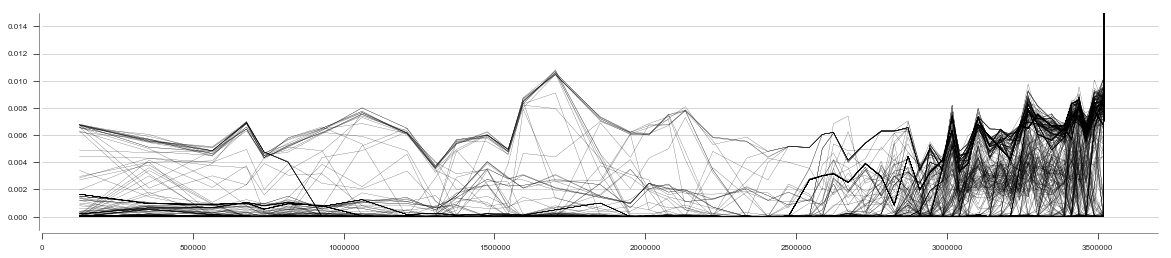

In [121]:
plot_divergence(haps_f1, hap_f1_anc, xlim=(0, 3700000));

## Sandbox

In [98]:
h = haps_f1[:, 2]
h

array([0, 0, 1, ..., 0, 0, 0], dtype=int8)

In [108]:
windows = allel.equally_accessible_windows(is_accessible, size=20000)
windows

array([[   25044,   222686],
       [  222687,   486928],
       [  486929,   642150],
       ..., 
       [49273137, 49293818],
       [49293819, 49315246],
       [49315247, 49336440]])

In [109]:
x = np.mean(windows, axis=1)
x

array([   123865. ,    354807.5,    564539.5, ...,  49283477.5,
        49304532.5,  49325843.5])

In [110]:
d, _, _ = allel.windowed_statistic(pos=pos_ehh, values=(h != hap_f1_anc), statistic=np.sum, windows=windows)
d

array([ 135.,  102.,   95., ...,   nan,   nan,   nan])

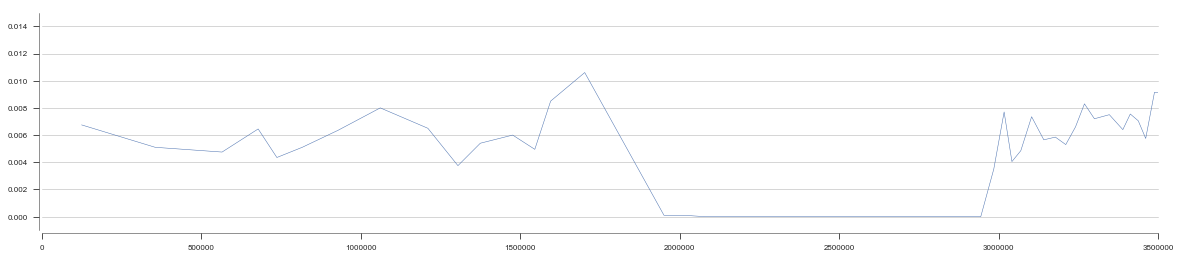

In [116]:
fig, ax = plt.subplots(figsize=(20, 4))
sns.despine(ax=ax, offset=3)
ax.plot(x, d/20000)
ax.set_xlim(0, 3500000)
ax.set_ylim(-0.001, 0.015)
ax.grid(axis='y')